# 必要なモジュールのimport

In [1]:
import os, sys, time
import evaluate
import numpy as np
import pickle
from utils.vit_util import get_misclf_info
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
from collections import Counter

ds_name = "c100"
k = 0

tgt_split = "repair"
if ds_name == "c100":
    num_classes = 100
else:
    NotImplemented, f"ds_name: {ds_name}"
pretrained_dir = getattr(ViTExperiment, ds_name).OUTPUT_DIR.format(k=k)
pred_out_dir = os.path.join(pretrained_dir, "pred_results", "PredictionOutput")
pred_out_path = os.path.join(pred_out_dir, f"{tgt_split}_pred.pkl")
with open(pred_out_path, "rb") as f:
    pred_out = pickle.load(f)
pred_labels = pred_out.predictions.argmax(-1)
true_labels = pred_out.label_ids

2024-09-29 19:02:37.734902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-29 19:02:38.917030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-29 19:02:38.917147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-09-29 19:02:38.917159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# 正解ラベルの分布描画
repair setはtrain setからランダムに取ってきているのでラベルごとのサンプル数にばらつきがある．

Min: 77, Max: 122, Mean: 100.0


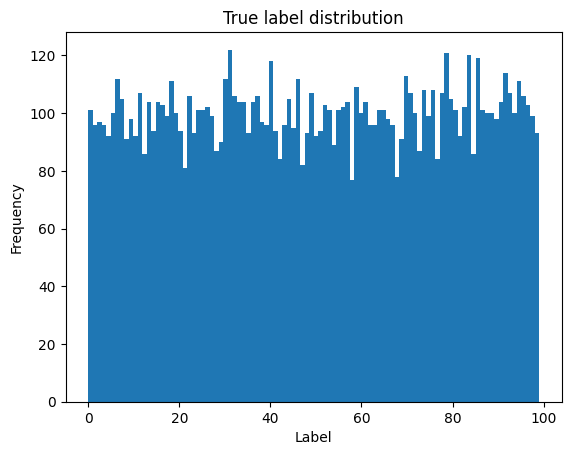

In [2]:
tl_cnter = Counter(true_labels)
# tl_cnterの最小と最大と平均を表示
print(f"Min: {min(tl_cnter.values())}, Max: {max(tl_cnter.values())}, Mean: {np.mean(list(tl_cnter.values()))}")
# true_labelの分布を表示
plt.figure()
plt.hist(true_labels, bins=num_classes)
plt.title(f"True label distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

# 誤分類情報の取得

In [3]:
mis_matrix, mis_ranking, mis_indices, met_dict = get_misclf_info(pred_labels, true_labels, num_classes)

Top 10 misclassification:
pred 52 -> true 47: 19 / 926 = 2.05 %
pred 61 -> true 10: 16 / 926 = 1.73 %
pred 11 -> true 35: 14 / 926 = 1.51 %
pred 2 -> true 11: 13 / 926 = 1.40 %
pred 11 -> true 2: 13 / 926 = 1.40 %
pred 47 -> true 52: 12 / 926 = 1.30 %
pred 55 -> true 72: 12 / 926 = 1.30 %
pred 35 -> true 11: 10 / 926 = 1.08 %
pred 81 -> true 13: 10 / 926 = 1.08 %
pred 99 -> true 78: 10 / 926 = 1.08 %
Top 10 worst precision scores:
label: 47, precision: 0.6707317073170732
label: 11, precision: 0.6981132075471698
label: 52, precision: 0.7394957983193278
label: 55, precision: 0.7592592592592593
label: 35, precision: 0.7674418604651163
label: 33, precision: 0.7830188679245284
label: 4, precision: 0.8
label: 96, precision: 0.8035714285714286
label: 10, precision: 0.8148148148148148
label: 61, precision: 0.8205128205128205
Top 10 worst recall scores:
label: 47, recall: 0.6707317073170732
label: 11, recall: 0.6915887850467289
label: 35, recall: 0.7096774193548387
label: 10, recall: 0.71739130

# ラベルごとのサンプル数と予測性能には相関がないことを確認
サンプル数が比較的少ないから性能が低いみたいなことがない，ということを確認したい．

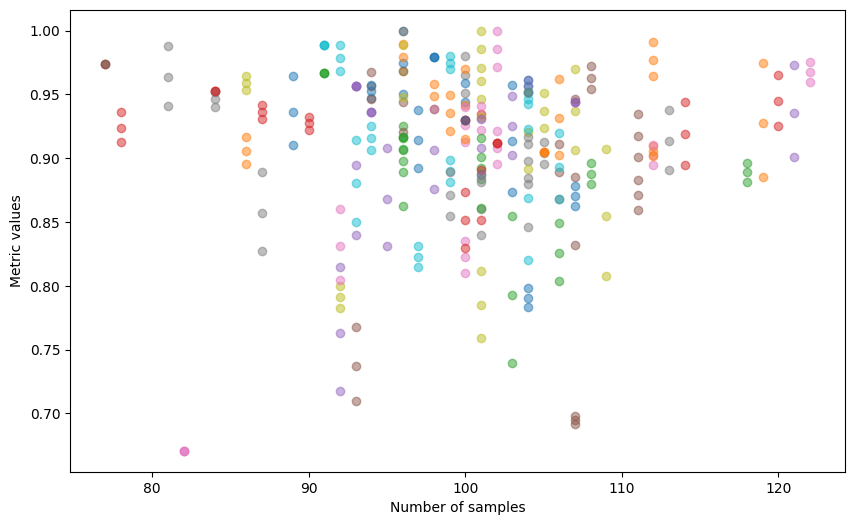

Correlation: 0.00890272158962515


In [4]:
# メトリクスの悪さとサンプル数の関係を描画
plt.figure(figsize=(10, 6))
x, y = [], []
for metric in ["f1", "precision", "recall"]:
    # ラベルごとに (サンプル数, メトリクスの値) を描画
    for label in tl_cnter.keys():
        plt.scatter(tl_cnter[label], met_dict[metric][label], label=metric, alpha=0.5)
        x.append(tl_cnter[label])
        y.append(met_dict[metric][label])
plt.xlabel("Number of samples")
plt.ylabel("Metric values")
plt.show()
# xとyの相関係数を表示
print(f"Correlation: {np.corrcoef(x, y)[0, 1]}")

# クラスごとのf1を描画


Bottom-5: [47 11 35 10 55]


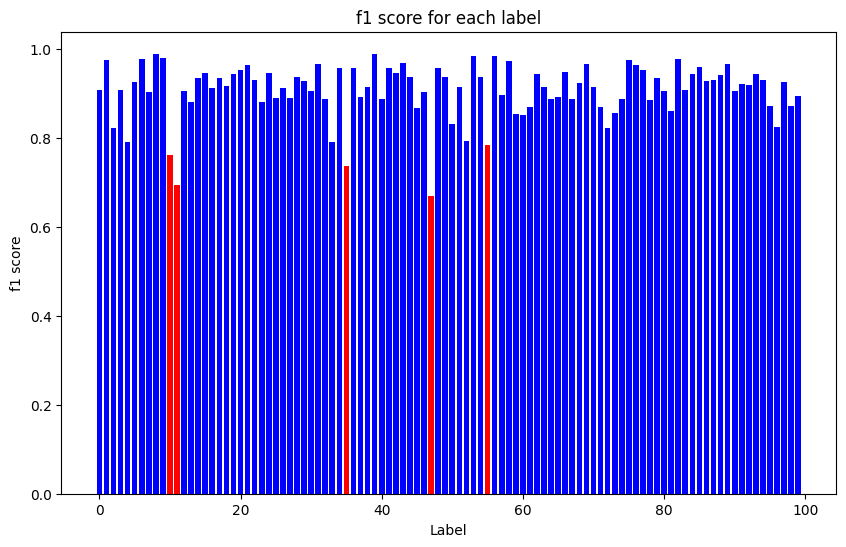

In [5]:
f1= met_dict["f1"]
# f1スコアのbottom-5
bottoms = np.argsort(f1)[:5]
print(f"Bottom-5: {bottoms}")
plt.figure(figsize=(10, 6))
for label in tl_cnter.keys():
    if label in bottoms:
        plt.bar(label, f1[label], color="red", label="bottom-5")
    else:
        plt.bar(label, f1[label], color="blue") 
plt.xlabel("Label")
plt.ylabel("f1 score")
plt.title("f1 score for each label")
plt.show()

# src-tgt型の誤分類の回数の分布を描画
組み合わせは 100x100-100 = 9,900 もある．よって1つ1つの誤分類の数は少ない．
実際ほとんど0 or 1です．最大でも19．

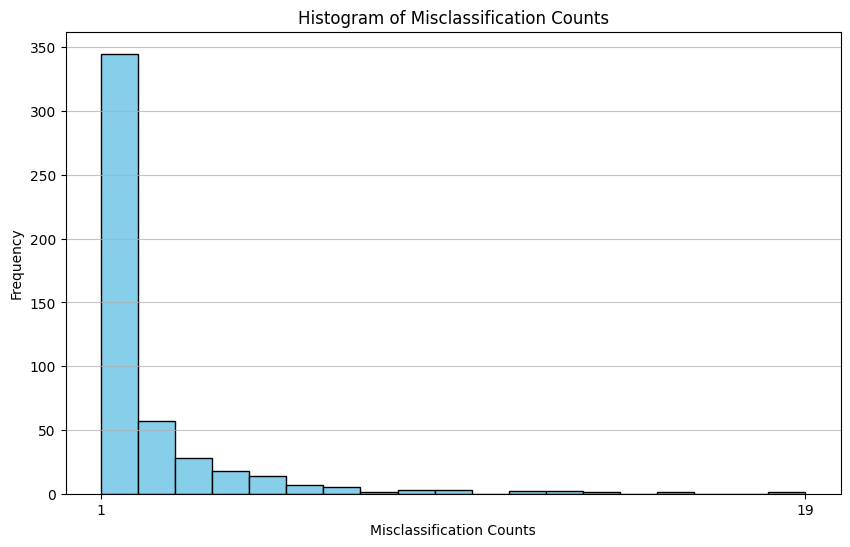

926


In [6]:
mis_counts = mis_matrix.flatten()
mis_counts = mis_counts[mis_counts > 0]
# Plotting histogram of misclassification counts
plt.figure(figsize=(10, 6))
plt.hist(mis_counts, bins=max(mis_counts), color='skyblue', edgecolor='black')
plt.title('Histogram of Misclassification Counts')
plt.xlabel('Misclassification Counts')
plt.ylabel('Frequency')
# 横軸は1とmax(mis_counts)だけ表示
plt.xticks([1, max(mis_counts)])
plt.grid(axis='y', alpha=0.75)
plt.show()
print(np.sum(mis_counts))

# any-tgt型の誤分類の回数の分布を描画
これなら100通りになるので誤分類の回数は比較的多くなる．
各ラベルlにおいて，lを何かに間違えたもしくは，何かをlに間違えた数を合計した数を数える．


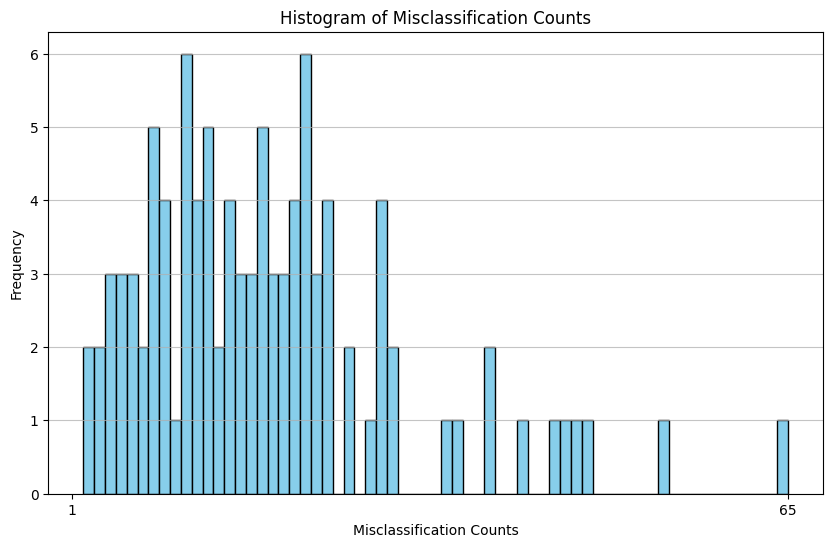

[11 47 35 52 55 33 10 96  4 72  2 59 50 60 61 95 81 71 98 40 45 74 73 13
 32 78 23 27 65 46 37 64 67 57 99 25 30 70  7 80  0 90 83 86 26 18  3 92
 38 16 91 12 51 63  5 22 97 79 94 87 29 17 84 49 44 93 68 88 14 15 54 62
 28 19 24 66 20 36 34 42 76 48 77 41 31 85 89 21 69 43 75  1  6 82 58  9
 53 56 39  8]
[65 54 47 46 45 44 41 38 38 35 34 30 30 29 29 29 29 28 26 26 24 24 24 24
 23 23 23 22 22 22 22 22 22 21 21 21 21 20 20 20 19 19 19 18 18 18 18 18
 17 17 17 16 16 16 15 15 15 15 14 14 13 13 13 13 13 12 12 12 12 11 11 11
 11 11 11 10  9  9  9  9  8  8  8  8  8  7  7  6  6  6  5  5  5  4  4  4
  3  3  2  2]


In [7]:
fn_for_each_label = np.sum(mis_matrix, axis=0) # 正解ラベルがlで間違えた
fp_for_each_label = np.sum(mis_matrix, axis=1) # 予測ラベルがlで間違えた
mis_for_each_label = (fn_for_each_label + fp_for_each_label)
# Plotting histogram of misclassification counts
plt.figure(figsize=(10, 6))
plt.hist(mis_for_each_label[mis_for_each_label > 0], bins=max(mis_for_each_label), color='skyblue', edgecolor='black')
plt.title('Histogram of Misclassification Counts')
plt.xlabel('Misclassification Counts')
plt.ylabel('Frequency')
plt.xticks([1, max(mis_for_each_label)])
plt.grid(axis='y', alpha=0.75)
plt.show()

# mis_for_each_labelのランキングを表示
mis_ranking = np.argsort(mis_for_each_label)[::-1]
print(mis_ranking)
print(mis_for_each_label[mis_ranking])

# ラベルごとのfp, fnの分布を確認
ラベルごとに，横軸にfp, 縦軸にfnを取る．100個の点ができるはず．
また，ラベルごとに fp+fnの値を棒グラフで表示する．

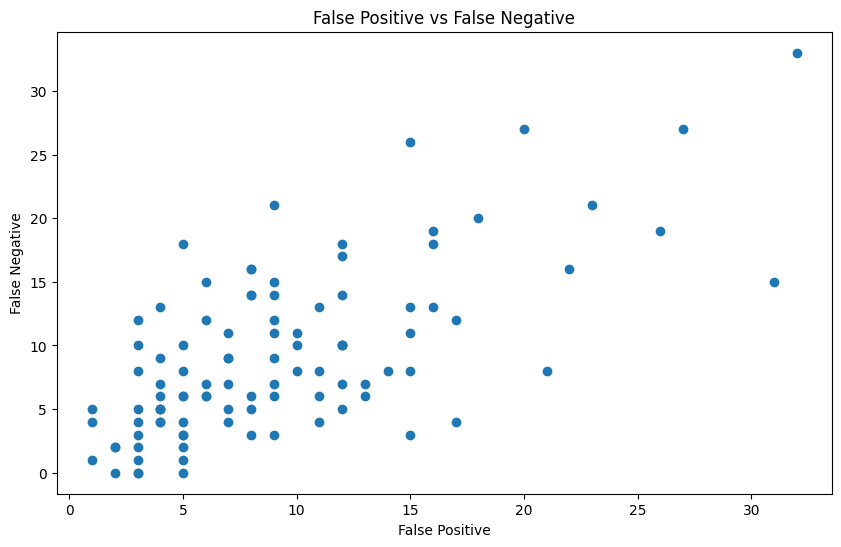

In [8]:
# ラベルごとに，横軸にfp, 縦軸にfnを取る
plt.figure(figsize=(10, 6))
plt.scatter(fp_for_each_label, fn_for_each_label)
plt.xlabel("False Positive")
plt.ylabel("False Negative")
plt.title("False Positive vs False Negative")
plt.show()

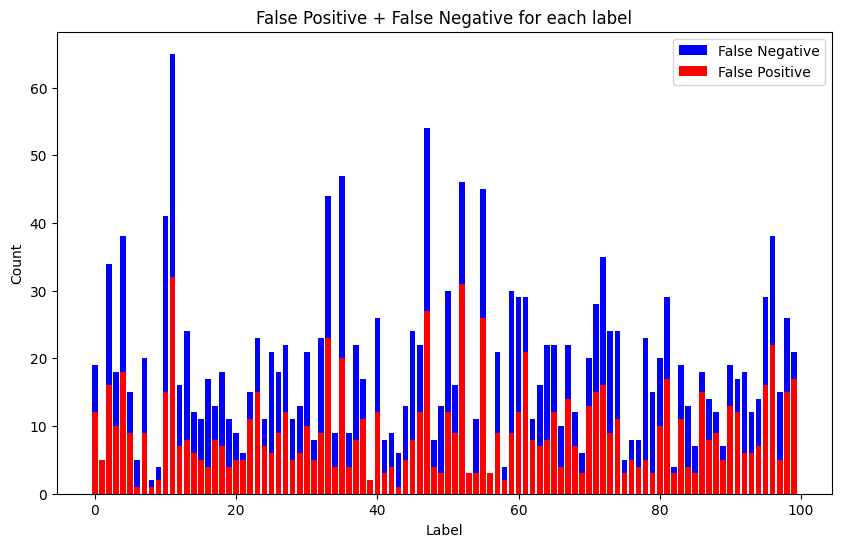

In [9]:
# ラベルごとに fp+fnの値を棒グラフで表示する
# fp+fnのうち，fpは赤，fnは青で表示
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), fp_for_each_label + fn_for_each_label, color='blue', label='False Negative')
plt.bar(range(num_classes), fp_for_each_label, color='red', label='False Positive')
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("False Positive + False Negative for each label")
plt.legend()
plt.show()

In [10]:
tl_cnter[47]-fn_for_each_label[47], fp_for_each_label[47], fn_for_each_label[47]

(55, 27, 27)

誤分類の種類
- src-tgt型: misclassifying the data with the tgt label to the src (a specific) label. single faultの候補は (クラス数^2 - クラス数) だけある.
- tgt型: misclassifying the data with the tgt label to any labels. single faultの候補はクラス数だけある.

つまり，fault type ごとのサンプル数は src-tgt型の方が小さくなる．クラス数が少なければ問題ないが多いと違いは顕著．

上のヒストグラムからわかること
- src-tgt型のfaultにした場合，350近くのsingle faultに対するサンプル数は1しかない．最大でも19．
- tgt型にしたら，single faultに対するサンプル数は増加する．最大では33．

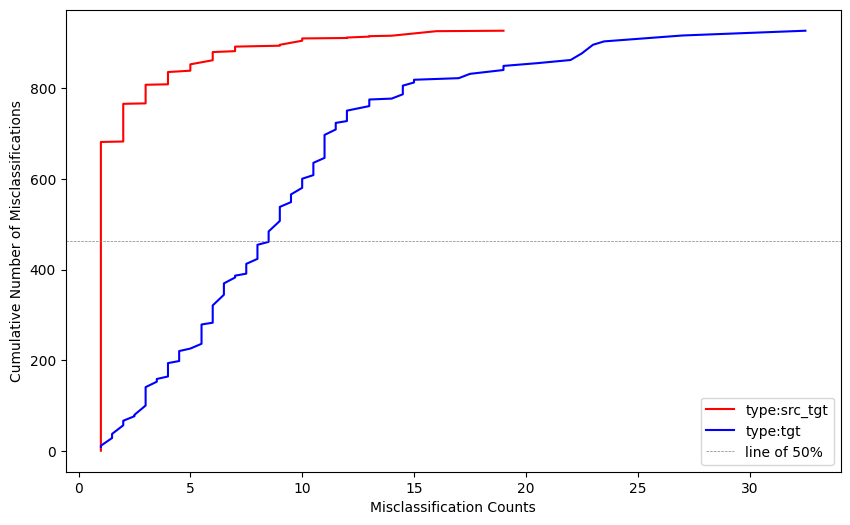

In [11]:
# 誤分類回数の累積分布をplt.plotを使って1枚のプロットに描く
# Plotting histogram of misclassification counts
plt.figure(figsize=(10, 6))
for mc in [mis_counts, mis_for_each_label[mis_for_each_label > 0]/2]:
    sorted_mc = np.sort(mc)
    # sorted_mcの中央値を取得
    median = np.median(sorted_mc)
    # sourted_mcの値がmedianとなる最大の位置を取得
    max_idx = np.where(sorted_mc == median)[0][-1]
    plt.ylabel('Cumulative Number of Misclassifications')
    plt.xlabel('Misclassification Counts')
    if np.array_equal(mc, mis_counts):
        color = 'r'
        label = "type:src_tgt"
    else:
        color = 'b'
        label = "type:tgt"
    plt.plot(sorted_mc, np.cumsum(mc), marker=None, linestyle='-', color=color, label=label)
plt.axhline(y=np.cumsum(mc)[-1]/2, color="gray", linestyle='--', linewidth=0.5, label="line of 50%")
plt.legend()
plt.show()